**Insper**  
**Redes Sociais**

# Projeto: Best Books Ever

**Jorás Oliveira**  
**Luciano Dias**  
**Tiago Seixas**


In [1]:
import sys
import re
import random
import math
import itertools

import netpixi
import seaborn as sns
from graph_tool import centrality, spectral
from matplotlib import pyplot as plt
from netpixi.integration.gt import *
from regression.integration.gt import *
import numpy as np

np.random.seed(27)

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


## Vertices

In [2]:
SIZE = 52_478
SAMPLES_SIZE = 2_000
samples = np.random.choice(SIZE, SAMPLES_SIZE, replace=False)

samples.sort()

g = Graph(directed=False) # não dirigido
g.add_vp('rating')
g.add_ep('weight')

print(f"Processando {SAMPLES_SIZE} vertices...")

next_id = 0
vertex_index = 0
header = []
row = []
genres = []
with open('./books_1.Best_Books_Ever.csv', 'rt') as file:
    for index, line in enumerate(file, -1):
        columns = re.split(r"(?<=\S),(?=\S|$)", line)

        if index == -1:
            header = columns
            continue

        if len(row) == 0:
            row = columns
        elif len(row) < len(header):
            row[-1] = "".join([row[-1], columns[0]])
            row.extend(columns[1:])
            
        if len(row) < len(header):
            continue
        
        if next_id not in samples:
            next_id += 1
            continue
        
        title = row[0]
        rating = row[3]
        col_genres = row[7]
        book_genres = col_genres[2:-2].split("', '")
        hash_genres = np.fromiter(map(hash, book_genres), np.int64)

        genres.append(hash_genres)
        
        vertex = g.add_vertex(vertex_index)
        vertex["rating"] = rating

        row = []
        next_id += 1
        vertex_index += 1

        if index % 100 == 0:
            sys.stdout.write(f"\r{vertex_index} {(vertex_index*100)//SAMPLES_SIZE}%")
            sys.stdout.flush()

print(f"\r{(SAMPLES_SIZE*100)//len(genres)}% dos vertices criados!")

Processando 2000 vertices...
100% dos vertices criados!


## Arestas

In [3]:
size = math.comb(len(genres), 2)
combinations = itertools.combinations(range(len(genres)), 2)

print(f"Processando {size} arestas...")

weights = []
def get_weight(g1, g2):
    inter = np.intersect1d(g1, g2)
    
    if len(inter) == 0:
        return 0.0
    
    weight_1 = np.array([len(g1) - index for index, genre in enumerate(g1) if genre in inter])
    weight_2 = np.array([len(g2) - index for index, genre in enumerate(g1) if genre in inter])
    a = sum((weight_1 + weight_2) / (len(g1) + len(g2))) / len(inter)
    
    return np.power(a, 1 / len(inter))

for index, (id_1, id_2) in enumerate(combinations):
    if index % 1_000 == 0:
        sys.stdout.write(f"\r{index} {(index*100)//size}%")
        sys.stdout.flush()

    weight = get_weight(genres[id_1], genres[id_2])

    if weight > 0.19:
        edge = g.add_edge(id_1, id_2)
        edge["weight"] = weight
    
        weights.append(weight)
    
print(f"\r{(size*100)//len(weights)}% das arestas criadas!")

Processando 1999000 arestas...
4000 0%

/tmp/ipykernel_525/3116047786.py:17: RuntimeWarning: invalid value encountered in power
  return np.power(a, 1 / len(inter))


100% das arestas criadas!


<AxesSubplot: ylabel='Count'>

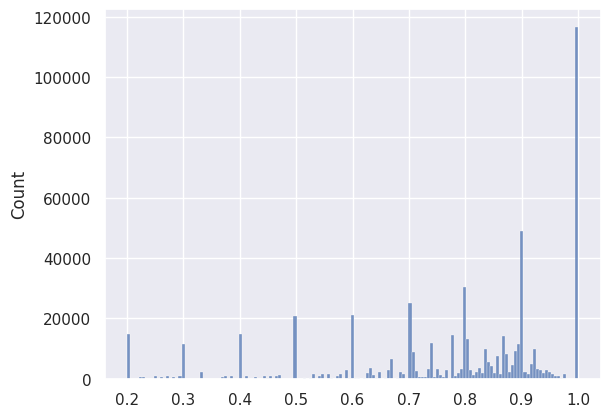

In [5]:
sns.histplot(weights)

In [6]:
# Salva o grafo
# Limpa e salva o grafo
g = gt_clean(g)

gt_save(g, 'best-books-ever.net.gz')

In [7]:
m = gt_draw.sfdp_layout(g)

gt_move(g, m)
gt_save(g, 'best-books-ever.net.gz')

In [ ]:
netpixi.render('best-books-ever.net.gz', infinite=True);